# Why does a topological layering emerge in neural networks?
_An example with sine_

## Libraries & Setup

In [1]:
import sys
sys.path.append('../')

In [2]:
from tqdm import tqdm
from math import sin, pi

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from funcs import topk_mask
from layers import CompleteLayer
from inits import Size, Like
from inits import (
    RandomNormal,
    RandomUniform,
    Ones,
    Zeros,
    Triu
)
from pruning import PruneEnsemble
from pruning import (
    NoPrune,
    RandomPrune,
    TopKPrune,
    DynamicTopK,
    ThresholdPrune,
    TriuPrune,
    TriuDamp,
    DynamicTriuDamp
)
import losses
from training import train
from evals import LineVisualiser, WeightVisualiser, DirectionalityVisualiser
import experiments

/home/yiding/Desktop/Research/induced-mlp/notebooks/../evals.py:129: SyntaxWarning: invalid escape sequence '\p'
  print(f'Directionality: {mean_dir:.3f} $\pm$ {std_dir:.3f}')


In [4]:
if torch.cuda.is_available():
    try:
        _ = torch.tensor([0], device='cuda')
        device = torch.device('cuda')
    except:
        device = torch.device('cpu')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cpu


/home/yiding/micromamba/envs/nsarc/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Generate Sine Data

In [5]:
x = torch.tensor(np.arange(0, 3, 0.01).reshape(-1, 2), dtype=torch.float32).to(device)
y = torch.unsqueeze(torch.sin(x).sum(1)/2, 1).to(torch.float32).to(device)
dataloader = DataLoader(TensorDataset(x, y), batch_size=10, shuffle=True)

## Simple Baseline

100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


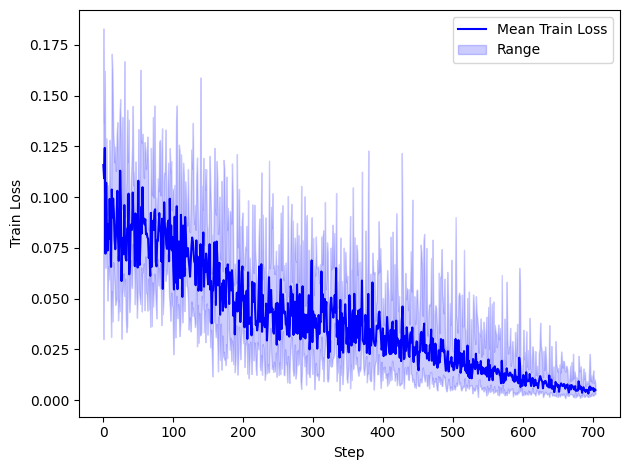

In [6]:
def baseline_setup():
    baseline = nn.Sequential(
        nn.Linear(2, 10, bias=True),
        nn.Sigmoid(),
        nn.Linear(10, 10, bias=True),
        nn.Sigmoid(),
        nn.Linear(10, 1, bias=True),
        nn.Sigmoid(),
    ).to(device)
    criterion = losses.MSELoss()
    optim = torch.optim.Adam(baseline.parameters(), lr=0.01)
    return {
        'model': baseline,
        'train_criterion': criterion,
        'optimiser': optim
    }

visualisers = experiments.run(
    tries=5,
    seed=1,
    setup_fn=baseline_setup,
    visualisers={
        'line': LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        )
    },
    n_epochs=1000,
    train_dataloader=dataloader,
    early_stop=3e-3
)

## Complete Network

100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Directionality: 0.792 $\pm$ 0.094


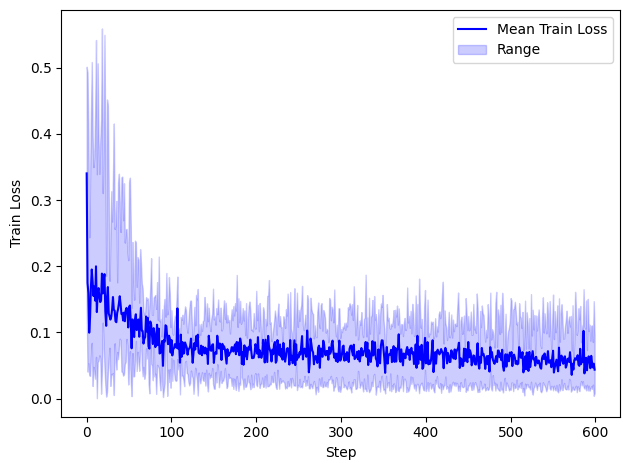

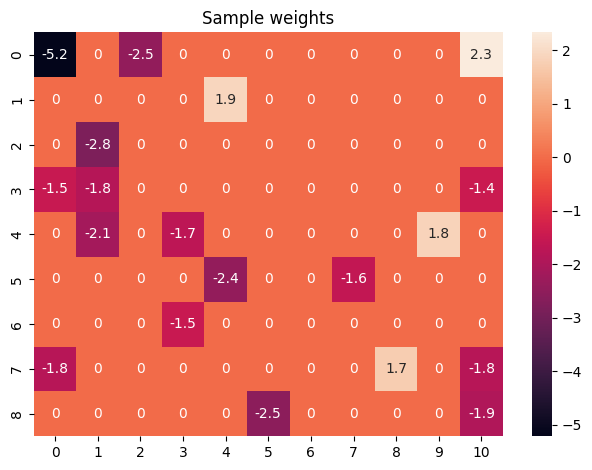

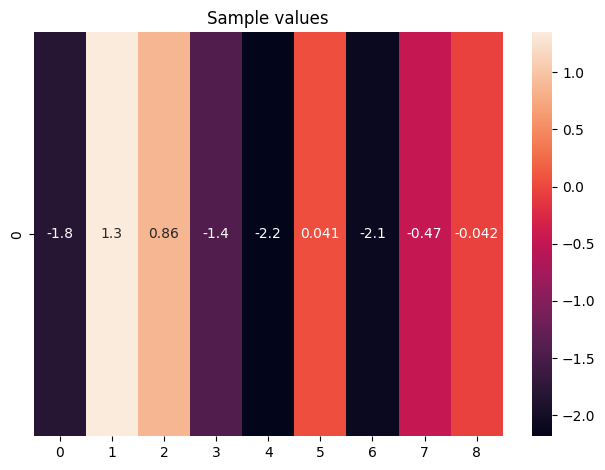

In [30]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=8,
        output_size=1,
        values_init=(RandomNormal, True),
        weights_init=(RandomNormal, True),
        bias_init=(Zeros, False),
        scores_init=(Ones, False),
        scores_k=1.,
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    its=3,
    pruner=PruneEnsemble({
        'values': NoPrune(),
        'weights': TopKPrune(k=0.2),
    }),
    visualisers={
        'directionality': DirectionalityVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            graphs=False
        ),
        'train': LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        # LineVisualiser(
        #     lambda r: (r['val_steps'], r['val_losses']),
        #     xlabel='Step',
        #     ylabel='Validation Loss'
        # ),
        'weights': WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['sample']  # ['mean', 'std', 'abs-mean', 'sample']
        ),
        'values': WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['sample']
        )
    },
    seed=20,
    tries=5,
    n_epochs=40,
    setup_fn=setup,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    # val_dataloader=dataloader,
    # val_criterion=losses.MSELoss(),
    early_stop=0,
)

Directionality: 0.888


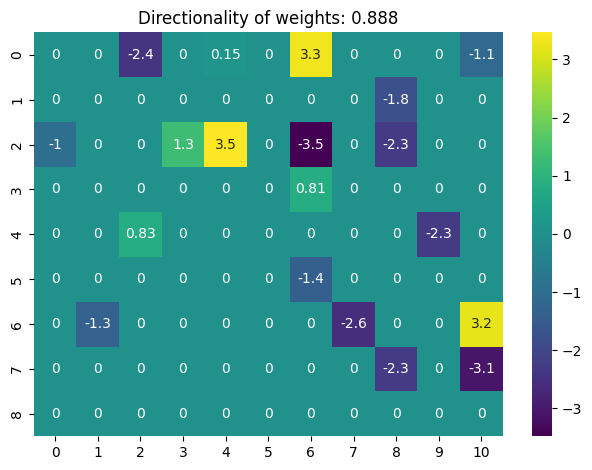

In [32]:
from utils import permute, brute_force_directionality

sample = visualisers['weights'].all_weights[2]
square = sample[:, :-2]
directionality, perm = brute_force_directionality(square, 2)
print(f'Directionality: {directionality:.3f}')

sns.heatmap(permute(sample, perm, perm+[9, 10]), annot=True, cmap='viridis')
plt.title(f'Directionality of weights: {directionality:.3f}')
plt.tight_layout()
plt.savefig('../media/weights/sine.pdf')
plt.show()


# UI-Plot

In [17]:
its = list(range(1, 11))
units = list(range(1, 10, 2))

ui_means = np.zeros((len(units), len(its)))
ui_stds = np.zeros((len(units), len(its)))

pbar = tqdm(total=len(units) * len(its))
for u_idx, u in enumerate(units):
    for i_idx, i in enumerate(its):

        def _setup():
            complete = CompleteLayer(
                input_size=2,
                hidden_size=u,
                output_size=1,
                values_init=(RandomNormal, True),  # try initialising differently
                weights_init=(RandomNormal, True),
                bias_init=(Zeros, False),
                scores_init=(Ones, False),
                scores_k=1.,
                activation=F.sigmoid,
                use_bias=False
            ).to(device)
            optim = torch.optim.Adam(complete.parameters(), lr=0.01)
            return {
                'model': complete,
                'optimiser': optim
            }

        visualisers, result = experiments.run(
            its=i,
            pruner=PruneEnsemble({
                'values': NoPrune(),
                'weights': DynamicTopK(k=0.5),
            }),
            visualisers={
                'directionality': DirectionalityVisualiser(
                    lambda r: r['model'].weights,
                    name = 'weights',
                    graphs=False
                )
            },
            seed=20,    # 10
            tries=5,
            n_epochs=40,
            setup_fn=_setup,
            train_dataloader=dataloader,
            train_criterion=losses.MSELoss(),
            early_stop=0
        )

        ui_means[u_idx, i_idx] = visualisers['directionality'].mean_dir
        ui_stds[u_idx, i_idx] = visualisers['directionality'].std_dir
        pbar.update(1)

100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Directionality: 0.814 $\pm$ 0.227


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Directionality: 0.861 $\pm$ 0.278


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Directionality: 0.850 $\pm$ 0.300


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Directionality: 0.839 $\pm$ 0.271


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Directionality: 0.830 $\pm$ 0.271


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Directionality: 0.827 $\pm$ 0.271


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Directionality: 0.825 $\pm$ 0.271


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Directionality: 0.824 $\pm$ 0.271


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Directionality: 0.823 $\pm$ 0.271


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Directionality: 0.823 $\pm$ 0.271


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Directionality: 0.602 $\pm$ 0.171


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Directionality: 0.747 $\pm$ 0.090


100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


Directionality: 0.819 $\pm$ 0.059


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Directionality: 0.662 $\pm$ 0.146


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Directionality: 0.662 $\pm$ 0.127


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Directionality: 0.649 $\pm$ 0.112


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Directionality: 0.636 $\pm$ 0.135


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Directionality: 0.636 $\pm$ 0.157


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Directionality: 0.674 $\pm$ 0.116


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Directionality: 0.673 $\pm$ 0.117


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Directionality: 0.676 $\pm$ 0.083


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Directionality: 0.729 $\pm$ 0.095


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Directionality: 0.711 $\pm$ 0.072


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Directionality: 0.680 $\pm$ 0.083


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Directionality: 0.703 $\pm$ 0.073


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Directionality: 0.695 $\pm$ 0.071


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


Directionality: 0.735 $\pm$ 0.065


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Directionality: 0.737 $\pm$ 0.063


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Directionality: 0.737 $\pm$ 0.068


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Directionality: 0.730 $\pm$ 0.056


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Directionality: 0.662 $\pm$ 0.040


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Directionality: 0.732 $\pm$ 0.028


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Directionality: 0.719 $\pm$ 0.061


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Directionality: 0.688 $\pm$ 0.022


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Directionality: 0.655 $\pm$ 0.013


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Directionality: 0.681 $\pm$ 0.041


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Directionality: 0.689 $\pm$ 0.023


100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


Directionality: 0.657 $\pm$ 0.036


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Directionality: 0.692 $\pm$ 0.034


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Directionality: 0.692 $\pm$ 0.035


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Directionality: 0.673 $\pm$ 0.043


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Directionality: 0.726 $\pm$ 0.036


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Directionality: 0.721 $\pm$ 0.044


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Directionality: 0.692 $\pm$ 0.032


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Directionality: 0.691 $\pm$ 0.048


100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Directionality: 0.688 $\pm$ 0.054


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Directionality: 0.691 $\pm$ 0.046


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Directionality: 0.681 $\pm$ 0.082


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Directionality: 0.689 $\pm$ 0.052


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Directionality: 0.680 $\pm$ 0.043


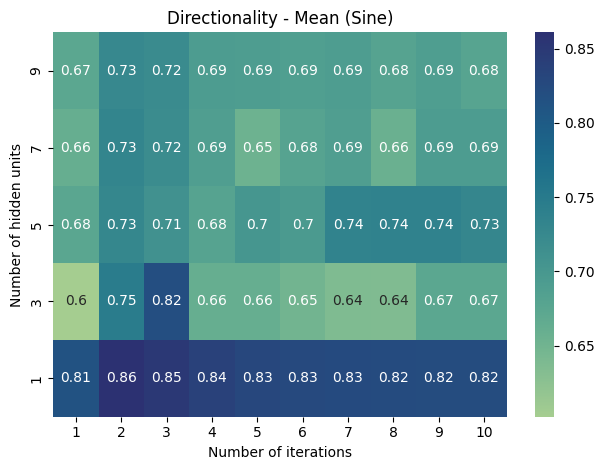

In [18]:
sns.heatmap(
    ui_means[::-1],
    annot=True,
    yticklabels=units[::-1],
    xticklabels=its,
    cmap='crest'
)

plt.title('Directionality - Mean (Sine)')
plt.xlabel('Number of iterations')
plt.ylabel('Number of hidden units')
plt.tight_layout()
plt.savefig('../media/ui/sine-mean.pdf')
plt.show()

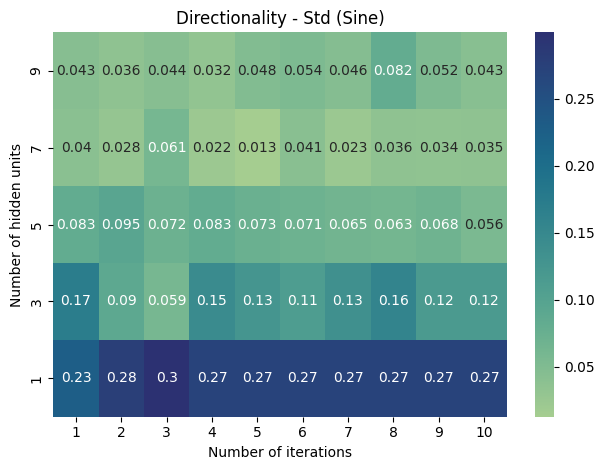

In [19]:
sns.heatmap(
    ui_stds[::-1],
    annot=True,
    yticklabels=units[::-1],
    xticklabels=its,
    cmap='crest'
)

plt.title('Directionality - Std (Sine)')
plt.xlabel('Number of iterations')
plt.ylabel('Number of hidden units')
plt.tight_layout()
plt.savefig('../media/ui/sine-std.pdf')
plt.show()

# VD-Plots

In [ ]:
vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

pruners = {
    'Random': (RandomPrune, 'p'),
    'Top-K': (TopKPrune, 'k'),
    'Dyn. Top-K': (DynamicTopK, 'k'),
    'Triu-damp': (TriuDamp, 'f'),
    'Dyn. Triu-damp': (DynamicTriuDamp, 'f')
}

vd_means = {
    p: []
    for p in pruners
}

vd_stds = {
    p: []
    for p in pruners
}

vd_maxs = {
    p: []
    for p in pruners
}

vd_mins = {
    p: []
    for p in pruners
}

pbar = tqdm(total=len(vals) * len(pruners))
for pn in pruners:
    for v_idx, v in enumerate(vals):

        def _setup():
            complete = CompleteLayer(
                input_size=2,
                hidden_size=8,
                output_size=1,
                values_init=(RandomNormal, True),  # try initialising differently
                weights_init=(RandomNormal, True),
                bias_init=(Zeros, False),
                scores_init=(Ones, False),
                scores_k=1.,
                activation=F.sigmoid,
                use_bias=False
            ).to(device)
            optim = torch.optim.Adam(complete.parameters(), lr=0.01)
            return {
                'model': complete,
                'optimiser': optim
            }

        visualisers, result = experiments.run(
            its=3,
            pruner=PruneEnsemble({
                'values': NoPrune(),
                'weights': pruners[pn][0](**{pruners[pn][1]: v}),
            }),
            visualisers={
                'directionality': DirectionalityVisualiser(
                    lambda r: r['model'].weights,
                    name = 'weights',
                    graphs=False
                )
            },
            seed=20,    # 10
            tries=5,
            n_epochs=40,
            setup_fn=_setup,
            train_dataloader=dataloader,
            train_criterion=losses.MSELoss(),
            early_stop=0
        )

        vd_means[pn].append(visualisers['directionality'].mean_dir)
        vd_stds[pn].append(visualisers['directionality'].std_dir)
        vd_maxs[pn].append(visualisers['directionality'].max_dir)
        vd_mins[pn].append(visualisers['directionality'].min_dir)
        pbar.update(1)

  2%|▏         | 1/45 [00:06<04:25,  6.04s/it]

Directionality: 0.678 $\pm$ 0.025


  4%|▍         | 2/45 [00:12<04:40,  6.52s/it]

Directionality: 0.706 $\pm$ 0.026


  7%|▋         | 3/45 [00:18<04:22,  6.24s/it]

Directionality: 0.723 $\pm$ 0.018


  9%|▉         | 4/45 [00:24<04:12,  6.16s/it]

Directionality: 0.710 $\pm$ 0.023


 11%|█         | 5/45 [00:30<04:04,  6.11s/it]

Directionality: 0.786 $\pm$ 0.032


 13%|█▎        | 6/45 [00:36<03:54,  6.01s/it]

Directionality: 0.831 $\pm$ 0.019


 16%|█▌        | 7/45 [00:42<03:46,  5.96s/it]

Directionality: 0.854 $\pm$ 0.050


 18%|█▊        | 8/45 [00:48<03:45,  6.09s/it]

Directionality: 0.867 $\pm$ 0.052


 20%|██        | 9/45 [00:55<03:40,  6.13s/it]

Directionality: 0.821 $\pm$ 0.089


 22%|██▏       | 10/45 [01:03<03:55,  6.72s/it]

Directionality: 0.773 $\pm$ 0.154


 24%|██▍       | 11/45 [01:11<04:01,  7.09s/it]

Directionality: 0.792 $\pm$ 0.094


 27%|██▋       | 12/45 [01:18<03:52,  7.06s/it]

Directionality: 0.700 $\pm$ 0.095


 29%|██▉       | 13/45 [01:25<03:46,  7.07s/it]

Directionality: 0.743 $\pm$ 0.091


 31%|███       | 14/45 [01:31<03:33,  6.88s/it]

Directionality: 0.749 $\pm$ 0.042


 33%|███▎      | 15/45 [01:38<03:26,  6.87s/it]

Directionality: 0.752 $\pm$ 0.044


 36%|███▌      | 16/45 [01:44<03:12,  6.64s/it]

Directionality: 0.725 $\pm$ 0.038


 38%|███▊      | 17/45 [01:50<03:01,  6.47s/it]

Directionality: 0.696 $\pm$ 0.021


 40%|████      | 18/45 [01:56<02:48,  6.23s/it]

Directionality: 0.678 $\pm$ 0.031


 42%|████▏     | 19/45 [02:02<02:38,  6.10s/it]

Directionality: 0.780 $\pm$ 0.191


 44%|████▍     | 20/45 [02:08<02:32,  6.10s/it]

Directionality: 0.802 $\pm$ 0.107


 47%|████▋     | 21/45 [02:14<02:28,  6.20s/it]

Directionality: 0.764 $\pm$ 0.088


 49%|████▉     | 22/45 [02:20<02:20,  6.10s/it]

Directionality: 0.751 $\pm$ 0.061


 51%|█████     | 23/45 [02:26<02:16,  6.21s/it]

Directionality: 0.722 $\pm$ 0.046


 53%|█████▎    | 24/45 [02:34<02:17,  6.53s/it]

Directionality: 0.706 $\pm$ 0.031


 56%|█████▌    | 25/45 [02:40<02:09,  6.46s/it]

Directionality: 0.684 $\pm$ 0.030


 58%|█████▊    | 26/45 [02:48<02:08,  6.76s/it]

Directionality: 0.672 $\pm$ 0.029


 60%|██████    | 27/45 [02:55<02:05,  7.00s/it]

Directionality: 0.664 $\pm$ 0.029


 62%|██████▏   | 28/45 [03:00<01:50,  6.50s/it]

Directionality: 0.996 $\pm$ 0.001


 64%|██████▍   | 29/45 [03:06<01:40,  6.27s/it]

Directionality: 0.998 $\pm$ 0.000


 67%|██████▋   | 30/45 [03:11<01:28,  5.91s/it]

Directionality: 0.999 $\pm$ 0.000


 69%|██████▉   | 31/45 [03:17<01:20,  5.77s/it]

Directionality: 0.999 $\pm$ 0.000


 71%|███████   | 32/45 [03:23<01:15,  5.81s/it]

Directionality: 1.000 $\pm$ 0.000


 73%|███████▎  | 33/45 [03:28<01:08,  5.69s/it]

Directionality: 1.000 $\pm$ 0.000


 76%|███████▌  | 34/45 [03:34<01:02,  5.65s/it]

Directionality: 1.000 $\pm$ 0.000


 78%|███████▊  | 35/45 [03:39<00:55,  5.55s/it]

Directionality: 1.000 $\pm$ 0.000


 80%|████████  | 36/45 [03:44<00:49,  5.48s/it]

Directionality: 1.000 $\pm$ 0.000


 82%|████████▏ | 37/45 [03:50<00:44,  5.53s/it]

Directionality: 0.995 $\pm$ 0.004


 84%|████████▍ | 38/45 [03:55<00:38,  5.54s/it]

Directionality: 0.998 $\pm$ 0.001


 87%|████████▋ | 39/45 [04:02<00:34,  5.80s/it]

Directionality: 0.999 $\pm$ 0.001


 89%|████████▉ | 40/45 [04:08<00:29,  5.95s/it]

Directionality: 0.999 $\pm$ 0.000


 91%|█████████ | 41/45 [04:14<00:24,  6.00s/it]

Directionality: 0.999 $\pm$ 0.000


 93%|█████████▎| 42/45 [04:20<00:18,  6.08s/it]

Directionality: 0.999 $\pm$ 0.000


 96%|█████████▌| 43/45 [04:26<00:11,  5.97s/it]

Directionality: 1.000 $\pm$ 0.000


 98%|█████████▊| 44/45 [04:32<00:06,  6.08s/it]

Directionality: 1.000 $\pm$ 0.000


100%|██████████| 45/45 [04:39<00:00,  6.32s/it]

Directionality: 1.000 $\pm$ 0.000


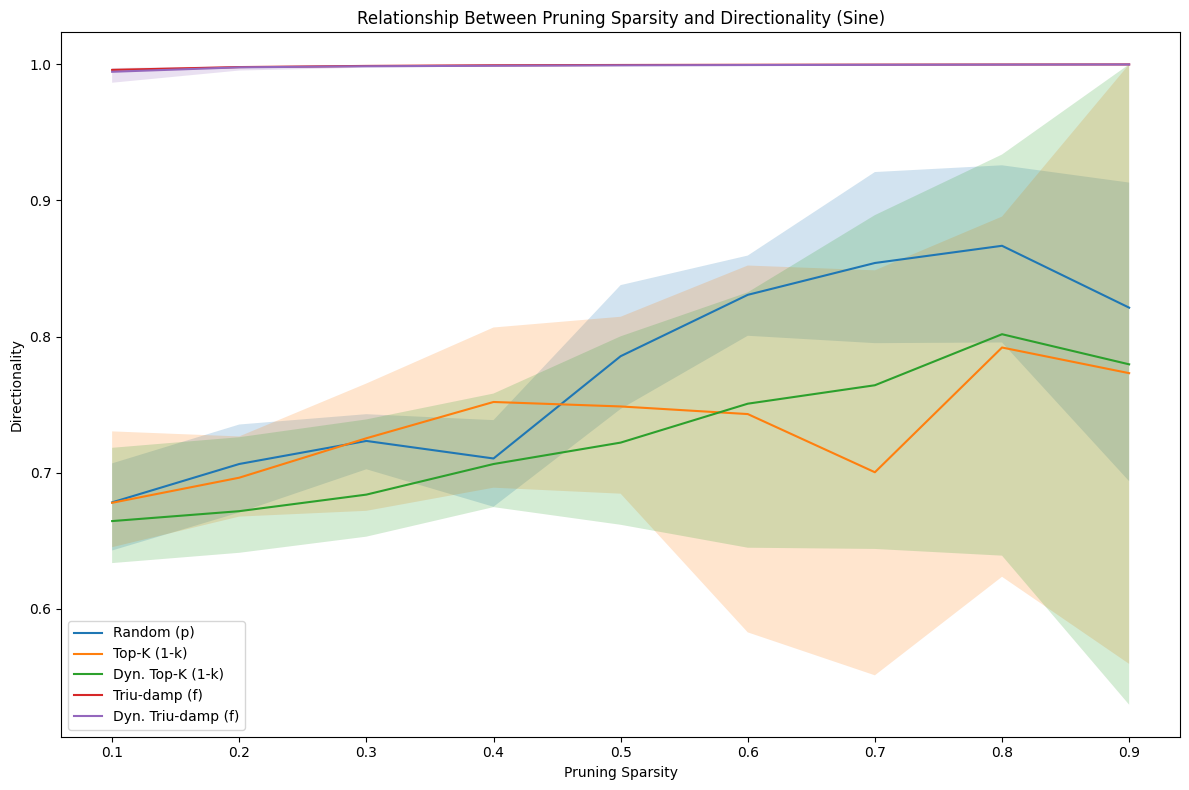

In [16]:
plt.figure(figsize=(12, 8))

for pn in pruners:
    if 'Top-K' in pn:
        plt.plot(vals[::-1], vd_means[pn], label=pn + f' (1-{pruners[pn][1]})')
        plt.fill_between(vals[::-1], vd_maxs[pn], vd_mins[pn], alpha=0.2)
    else:
        plt.plot(vals, vd_means[pn], label=pn + f' ({pruners[pn][1]})')
        plt.fill_between(vals, vd_maxs[pn], vd_mins[pn], alpha=0.2)

plt.legend()
plt.xlabel('Pruning Sparsity')
plt.ylabel('Directionality')
plt.title('Relationship Between Pruning Sparsity and Directionality (Sine)')
plt.tight_layout()
plt.savefig('../media/vd/sine.pdf')
plt.show()